Importando bibliotecas

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
df = pd.read_csv("D:\\github\\SIGAMA-data-analysis\\data\\dataset_normalizado_anonimizado.csv")

In [63]:
mes_map = {
    "Janeiro": 1, "Fevereiro": 2, "Março": 3, "Abril": 4,
    "Maio": 5, "Junho": 6, "Julho": 7, "Agosto": 8,
    "Setembro": 9, "Outubro": 10, "Novembro": 11, "Dezembro": 12
}

df["mes_num"] = df["mês"].map(mes_map)

df["data"] = pd.to_datetime(
    dict(year=df["ano"], month=df["mes_num"], day=df["dia"])
)

df["approved"] = (df["status"] == "APROVADO").astype(int)

Empresa X Pessoa Proportion

In [64]:
type_counts = (
    df["tipo_de_conta"]
      .value_counts()
      .reset_index()
)

type_counts.columns = ["tipo_de_conta", "total_requests"]

type_counts

,tipo_de_conta,total_requests
0,Pessoa Física,1737
1,Empresa,96


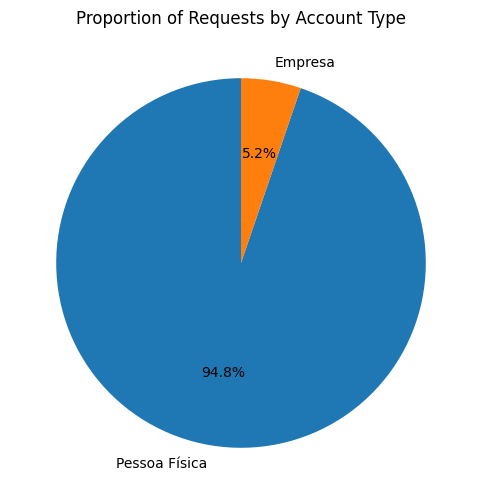

In [65]:
plt.figure(figsize=(6,6))

plt.pie(
    type_counts["total_requests"],
    labels=type_counts["tipo_de_conta"],
    autopct="%1.1f%%",
    startangle=90
)

plt.title("Proportion of Requests by Account Type")

plt.show()

Approval Funnel Over Time

In [66]:
daily = (
    df.groupby(["data", "tipo_de_conta"])
      .agg(total=("approved", "count"),
           approved=("approved", "sum"))
      .reset_index()
)

daily["approval_rate"] = daily["approved"] / daily["total"]

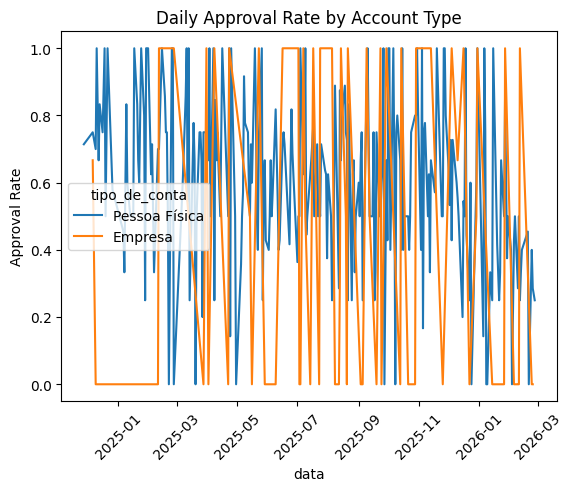

In [67]:
plt.figure()
sns.lineplot(data=daily, x="data", y="approval_rate", hue="tipo_de_conta")
plt.title("Daily Approval Rate by Account Type")
plt.ylabel("Approval Rate")
plt.xticks(rotation=45)
plt.show()

Attempts per year

In [68]:
monthly = (
    df.groupby(["ano", "mes_num"])
      .size()
      .reset_index(name="total_requests")
      .sort_values(["ano", "mes_num"])
)

In [69]:
monthly["year_month"] = pd.to_datetime(
    dict(year=monthly["ano"], month=monthly["mes_num"], day=1)
)

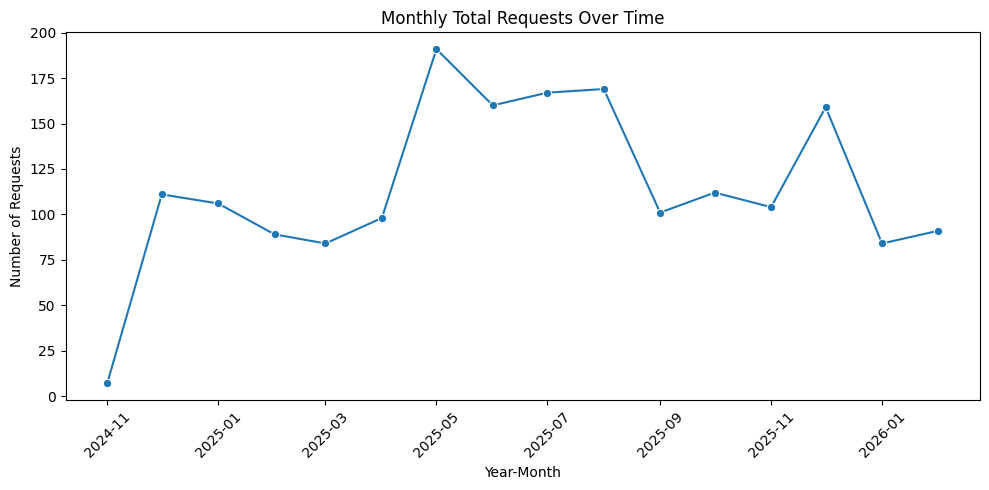

In [70]:
plt.figure(figsize=(10, 5))

sns.lineplot(
    data=monthly,
    x="year_month",
    y="total_requests",
    marker="o"
)

plt.title("Monthly Total Requests Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Requests")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [71]:
monthly_type = (
    df.groupby(["ano", "mes_num", "tipo_de_conta"])
      .size()
      .reset_index(name="total_requests")
      .sort_values(["ano", "mes_num"])
)

In [72]:
monthly_type["year_month"] = pd.to_datetime(
    dict(year=monthly_type["ano"], month=monthly_type["mes_num"], day=1)
)

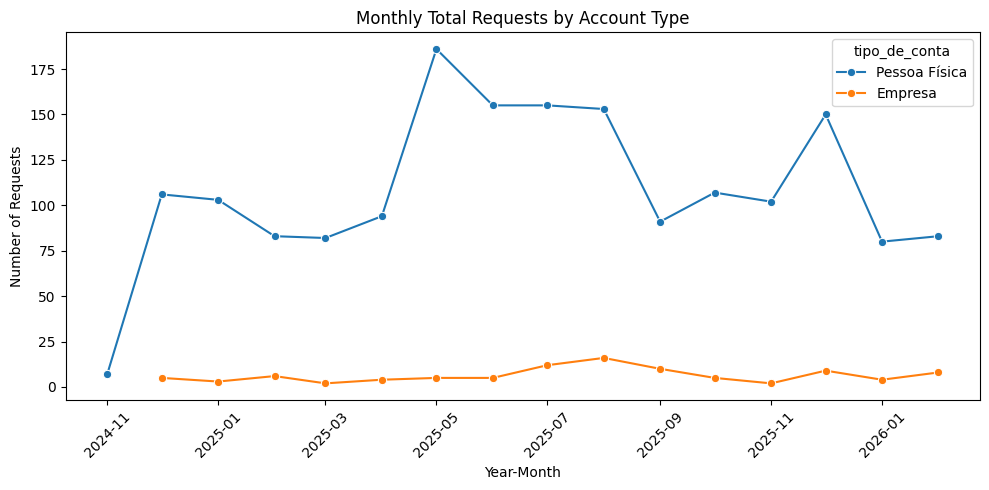

In [73]:
plt.figure(figsize=(10, 5))

sns.lineplot(
    data=monthly_type,
    x="year_month",
    y="total_requests",
    hue="tipo_de_conta",
    marker="o"
)

plt.title("Monthly Total Requests by Account Type")
plt.xlabel("Year-Month")
plt.ylabel("Number of Requests")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Attempts Until Approval Distribution

In [74]:
df = df.sort_values(["cpf_hash", "data"])
df["attempt_number"] = df.groupby("cpf_hash").cumcount() + 1

In [75]:
def attempts_until_approval(group):
    approved_rows = group[group["approved"] == 1]
    if len(approved_rows) == 0:
        return len(group)
    return approved_rows["attempt_number"].iloc[0]

attempts = (
    df.groupby(["cpf_hash", "tipo_de_conta"])
      .apply(attempts_until_approval)
      .reset_index(name="attempts_until_approval")
)

C:\Users\enzom\AppData\Local\Temp\ipykernel_22728\1405609603.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(attempts_until_approval)


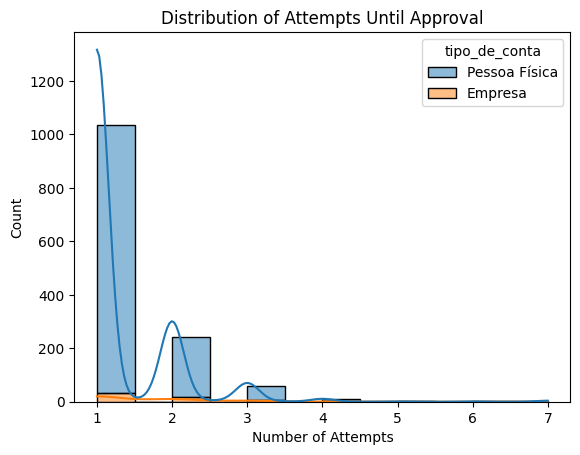

In [76]:
plt.figure()
sns.histplot(
    data=attempts,
    x="attempts_until_approval",
    hue="tipo_de_conta",
    kde=True,
    multiple="stack"
)
plt.title("Distribution of Attempts Until Approval")
plt.xlabel("Number of Attempts")
plt.show()

Heatmap – Volume by Day of Month

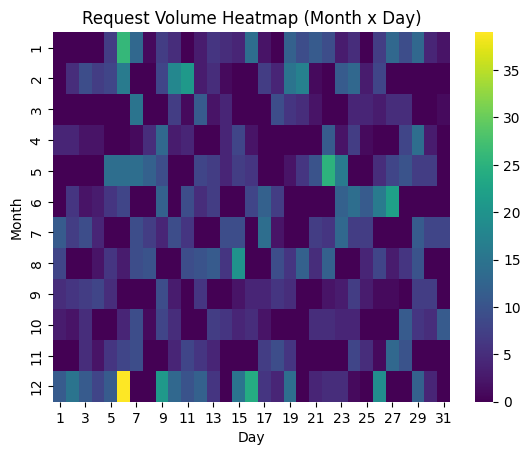

In [77]:
heat = (
    df.groupby(["mes_num", "dia"])
      .size()
      .unstack(fill_value=0)
)

plt.figure()
sns.heatmap(heat, cmap="viridis")
plt.title("Request Volume Heatmap (Month x Day)")
plt.xlabel("Day")
plt.ylabel("Month")
plt.show()

Approval Rate by Account Type

In [78]:
rate_type = (
    df.groupby("tipo_de_conta")
      .agg(total=("approved", "count"),
           approved=("approved", "sum"))
)

rate_type["rejected"] = rate_type["total"] - rate_type["approved"]
rate_type = rate_type[["approved", "rejected"]]
rate_prop = rate_type.div(rate_type.sum(axis=1), axis=0)

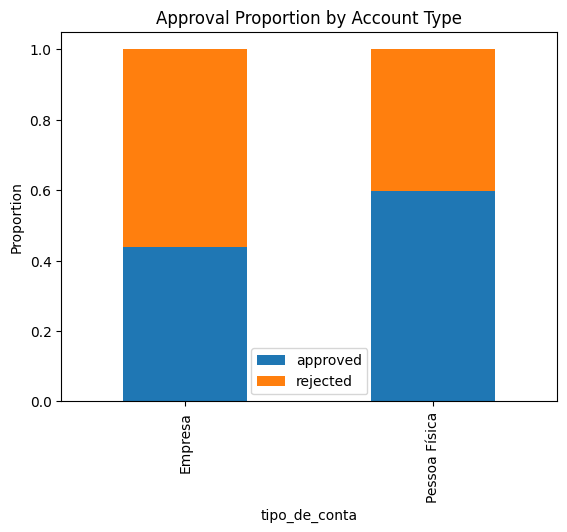

In [79]:
rate_prop.plot(kind="bar", stacked=True)
plt.title("Approval Proportion by Account Type")
plt.ylabel("Proportion")
plt.show()

Attempts vs Probability of Approval

In [80]:
attempt_success = (
    df.groupby("attempt_number")
      .agg(total=("approved", "count"),
           approved=("approved", "sum"))
      .reset_index()
)

attempt_success["probability"] = (
    attempt_success["approved"] / attempt_success["total"]
)

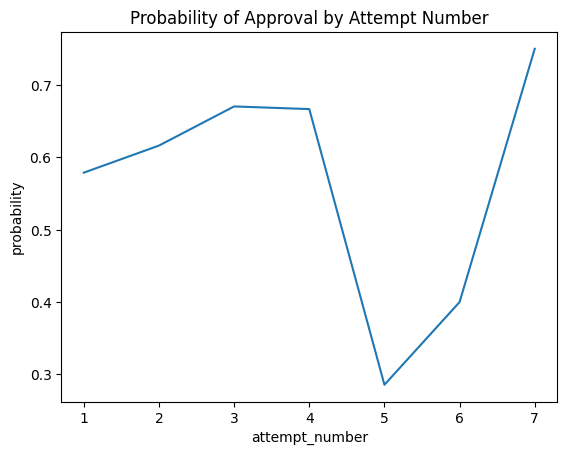

In [81]:
plt.figure()
sns.lineplot(data=attempt_success, x="attempt_number", y="probability")
plt.title("Probability of Approval by Attempt Number")
plt.show()